# Intro to Planet Formation Research Using mm Interferometry

Interferometry is an observing method that astronomers utilise to achieve a balance between sensitivity and spatial resolution that would otherwise be impossible to achieve.

Today we will be analysing data from the Atacama Large Millimetre/sub-millimetre Array, an interferometer that is situated in the north of Chile. It is comprised of 66 antennas all working at the same time.


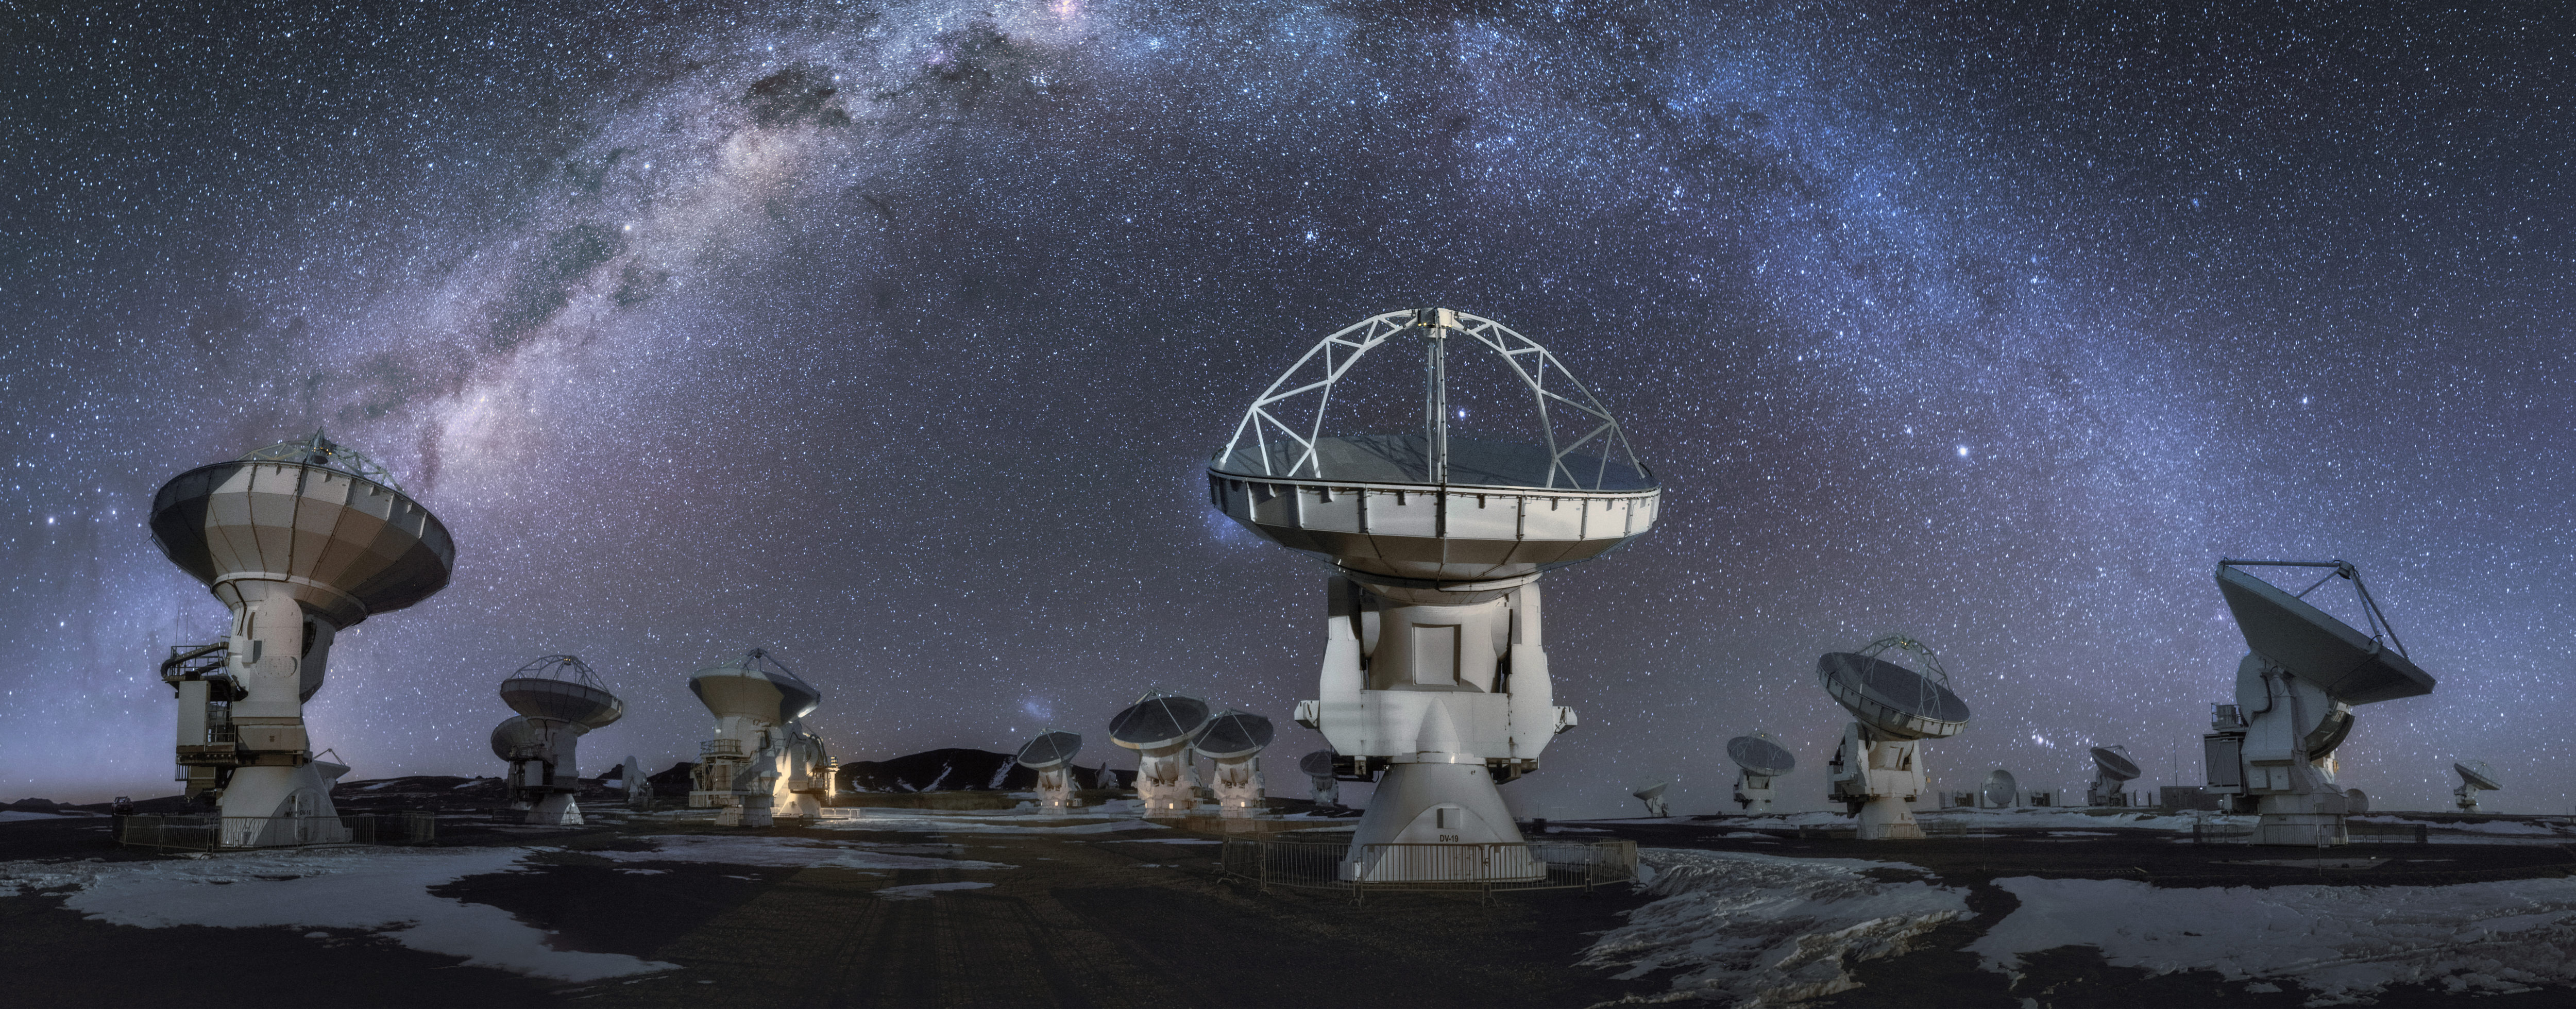

# Planet Formation with ALMA


Specifically, we will be working on images of a 'protoplanetary disc' - the environment around a young star comprised of gas and dust in which planets are formed. ALMA is an ideal instrument for observing cold gas and dust in the universe, which is exactly what we expect in the outer regions of protoplanetary discs. Our own Solar System once formed from a protoplanetary disc (artist's impression below - Image Credit: NASA)


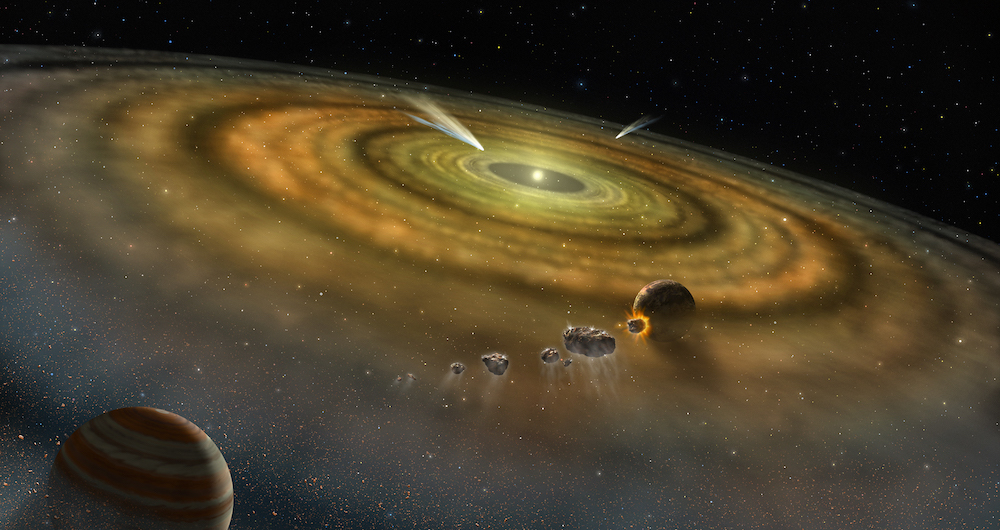



---

# Our Goal

In the following exercise, we will analyse an image of a protoplanetary disc around a well known star, over 300 light years away. We will analyse the emission we have detected from the protoplanetary disc, and quantify how much planet-building material remains in the system. By inspecting the image we will search for rings in the disc, and should we find them, estimate what mass of planet would be required to create such a structure. We can then compare our predicted planet properties to the properties of confirmed exoplanet detections and try to interpret what this can tell us about planet formation and planet detection methods.


Today we will be working with data that were obtained by the DSHARP survey using ALMA, which is now all publically available at this link: https://almascience.eso.org/almadata/lp/DSHARP/ .




# Loading and inspecting the data

**First, we must begin by downloading an image that we will use**

In [ ]:
import gdown
file_id='1NTN-GnvbfrWs47IjfBXD2PtYWlyxTQWD'
outputfile='HD163296_continuum.fits'
gdown.download(f"https://drive.google.com/uc?id={file_id}",outputfile, quiet=False)

**We also need to import some useful packages for analysing astronomical data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd

!pip install gofish
!pip install astropy
#!pip install dbnets

from gofish import imagecube
import astropy.constants as const
from astropy.io import fits
from scipy.signal import find_peaks


**Now we are ready to go!**

First let's inspect the image we have. To do this we extract the data from the fits file and then select the data axes which are important to us.

In [3]:

image='HD163296_continuum.fits'
image_data = fits.getdata(image, memmap=True)
# we can extract the data from this fits file using the above function 'get_data' from astropy
image_data = image_data[0, 0, :, :]
# fits images contain some extra axes that we don't need, so we remove the unneccesary axes

.fits files are a useful way of storing large data files alongside useful meta data. We will use some of this information later, so we can read and save it from the .fits file as follows:

In [ ]:
hdulist = fits.open(image)
header = hdulist[0].header
# We will use this information later, right now we can print the entire header
# to see what it looks like, and see some of the information it holds:
print(repr(header))

**Now we have our data, we can plot an image using matplotlib:**

In [ ]:
plt.figure()
plt.imshow(image_data, origin='lower', cmap='hot') #origin='lower' ensures the image is shown the correct way up
plt.xlim([1000,2000])  # these limits are given in pixels
plt.ylim([1000,2000])  # adjust them to zoom in on different parts of the disc
plt.colorbar()

**Great ! We have an image of a protoplanetary disc**

**--- Questions ---**

What substructures do you see?

Are there rings in this disc? If so how many?

# Section A) Basic image analysis - measurement of flux and background noise

Now we can calculate some key properties of this image.

These will be:


***Peak Flux***: The maximum flux that is measured in the whole image. this will be in units of Jy/beam - a unit of brightness that is used in interferometry  equal to  10^{−26} W m^2 Hz^1 sr^2

***RMS***: A measured of the brightness of the background noise, also in units of Jy/beam

***Integrated flux***: The total amount of intensity coming from the area of the disc


**The first property is simple -  what is the brightest value in the image, and where is it?**


In [6]:

peak_flux = np.max(image_data)

loc_peak_flux = np.where(image_data==peak_flux)

print('The peak flux measured in the image of HD163296 is {:.3} mJy/beam, found at pixel {},{}'.format(peak_flux/1e3, loc_peak_flux[0], loc_peak_flux[1]))

The peak flux measured in the image of HD163296 is 4.26e-06 mJy/beam, found at pixel [1500],[1508]


**In order to measure the rms , we need to aim to measure an empty region of sky - i.e. one in which there is only background noise and no astronomical object.**

We should therefore identify a region of sky that is away from the disc at the centre of the image. We can do so as follows:






In [7]:
# write a function that calculates the distance of a pixel from the center

def calculate_distance_from_center(shape):
    center_x = shape[1] // 2
    center_y = shape[0] // 2
    y, x = np.indices(shape)
    distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    return distance

# write a function to define an annulus between two distances, R1 and R2,
# that contain no 'real' emission, just noise:

def apply_noise_mask(data, R1, R2):
    distance = calculate_distance_from_center(data.shape)
    mask = (distance > R1) & (distance < R2)
    return mask


With these two functions we can now define a region, or 'apply a mask' to the image, and measure flux only in here.

In [ ]:

# Define the inner and outer radius at which we will measure the background noise
R1 = # try 500
R2 = # try 800
# we want these values, here given in pixels, to enclose an annulus
# in the image where there is no disc emission, so lets check this is the case

# Apply this mask to our data
mask = apply_noise_mask(image_data, R1, R2)

#  Now we can plot the mask to make sure we are not including any disc emission
plt.imshow(image_data, cmap='hot', origin='lower')
plt.colorbar()
plt.contour(mask, colors='limegreen', linewidths=5, origin='lower')
plt.title('Noise will be measured from between the two green circles')
plt.show()

**--- Questions ---**

Is this a good mask for measuring noise?

Is there any bright emission within the two circles? What does it mean if there is?

Should we adjust R1 and R2?



---

Ok, now lets make the noise measurement. RMS stands for root-mean-square, which describes what we will be calculating with the following function:

In [10]:
def calculate_rms(data, mask):
    masked_values = data[mask] #use the mask we created above
    rms = np.sqrt(np.mean(masked_values**2)) # take the root mean square
    return rms

# Now we can calculate the RMS of the masked values
rms = calculate_rms(image_data, mask)
print('The background noise value, aka the RMS, that we measure is {:.3} Jy/beam'.format(rms))



The background noise value, aka the RMS, that we measure is 2.52e-05 Jy/beam




---


**A useful quantity used by astronomers to determine the strength of a signal in astronomical data is the signal-to-noise ratio**

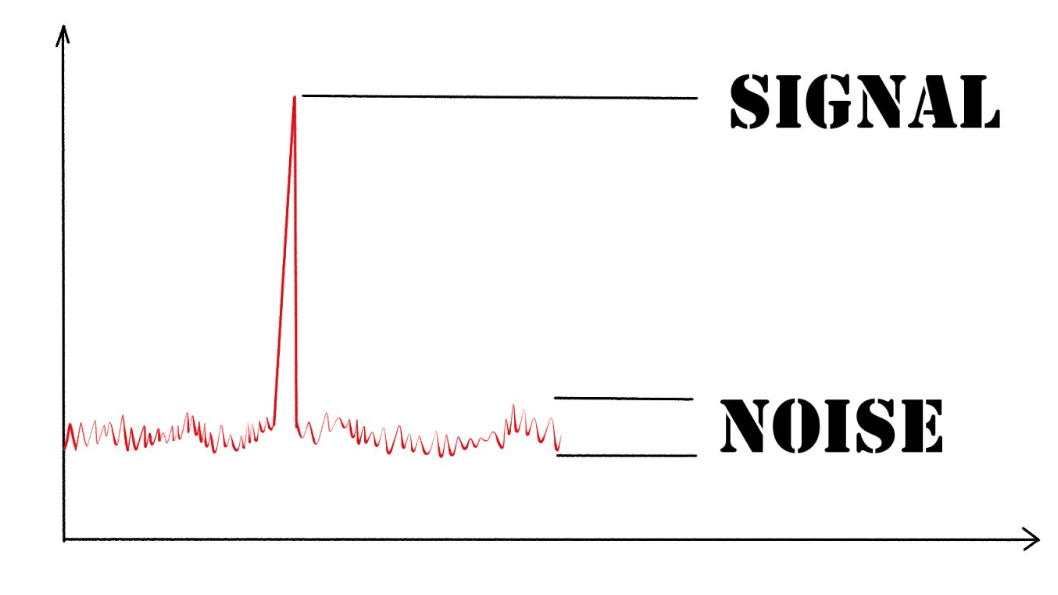

**We can calculate this using the two parameters we have measured so far:**

In [ ]:
SNR=peak_flux/rms
print('The SNR of the image is ~{:.0f}'.format(SNR))



---


**To measure our final key property, the integrated flux, we must sum up the significant emission we measure within the image**

In order to do this we must define what we mean by significant emission. In our case, we can set two requirements:


**1)** Emission should be significant compared to our measured noise level

So we must set the noise level below which we want our mask to ignore any data. Typically this is set to 3 x rms. Try multiplying the rms level by different values and see how it changes the appearance of the mask that we plot below

In [12]:
noise_cut= #try 3*rms to begin with, then experiment

**2)** We should only conside emission from the centre of the image, in case there are any background stars or contaminants in the field. For now, we can use a size we have already used above :

In [13]:
Rmax= R1

Now we can use our definitions to write a function that will calculate integrated flux for us:

In [14]:
def convert_flux_units_to_Jy(measured_flux, header, disc_mask):
    pix_size_x = header.get('CDELT1')
    pix_size_y = header.get('CDELT2')
    beam_major = header.get('BMAJ')
    beam_minor = header.get('BMIN')

    pix_per_mask=np.sum(disc_mask)
    bm_area=2*np.pi*beam_major*beam_minor
    pix_area=np.abs(pix_size_x)*np.abs(pix_size_y)

    pix_per_beam=bm_area/pix_area
    return measured_flux*pix_per_beam/pix_per_mask

def calculate_integrated_flux(data, Rmax, rms, header):
    # use our prior function for distance calculation
    distance = calculate_distance_from_center(data.shape)
    # apply the distance and brightness requirements
    disc = (distance < Rmax ) & (data > rms )
    # sum up the values in this defined disc area
    int_flux = np.sum(image_data[disc])
    # a conversion of units from Jy/beam to Jy
    int_flux_Jy=convert_flux_units_to_Jy(int_flux, header, disc)
    return int_flux_Jy, disc

In [ ]:
pix_size_x = header.get('CDELT1')
print(pix_size_x)

This function will calculate the integrated flux, but also return the mask we used.

**So let's do it**

In [ ]:
int_flux, disc_mask=calculate_integrated_flux(image_data, R1, noise_cut, header)

print('The integrated flux measured from the dust disc of HD163296 is {} Jy/beam'.format(int_flux))

# lets also check if the mask we used makes sense:
disc_y, disc_x = np.where(disc_mask)

plt.figure
plt.imshow(image_data,cmap='gray', origin='lower' )
plt.scatter(disc_x, disc_y, color='red', s=1)  # s=1 to make the points small
plt.xlim(1000,2000)
plt.ylim(1000,2000)



**--- Questions ---**

Does this mask for measuring integrated flux look ok?

If there are lots of individual pixels being selected away from the main disc dust distribution (i.e. if you see lots of red dots towards the edges of the image) then maybe a higher noise_cut value will be useful. If you try a different noise_cut, how does this affect the flux you measure?
>Hint: you might double-check your result with that of Andrews et al. 2018, see Table 4, $F_\nu$,  https://arxiv.org/pdf/1812.04040

What is the ideal multiple of rms you can find? What integrated flux do you measure with this mask?


# **Calculation of disc mass**

Our SNR is very high ( SNR = 3 is considered the minimum to claim a detection, here we have much larger!). So we can feel confident that we are detecting a high proportion of the disc's total emission at this observing wavelength, which is about 1.3mm.

One thing we can already do with our measured properties is to make an estimate of the mass of solid material within this system, this means we can weigh how much planet-building material remains.

To do this, we can adopt an equation commonly used in published articles that relates the observed flux, $S_\nu$ , to the mass of the emitting dust particles, by assuming some properties about how the dust emits:

$ S_{\nu} = \frac{B_\nu \kappa M_{\rm disc}}{d^2}  $,

 where $ S_{\nu}$ is the observed brightness, $B_\nu$ is the Planck function which calculates the expected blackbody emission at our observing frequency, $\kappa$ describes the behaviour of the dust emission and $d$ is the distance from Earth.

In [17]:
def planck(T, nu):
    # function for calculating black body radiation
    h=const.h.value
    c=const.c.value
    k=const.k_B.value
    return ( (2*h*nu**3)/ c**2) * (np.exp(h*nu / (k*T)) -1 )**-1


def dust_mass(int_flux, distance, temperature,frequency):
    d=distance*const.pc.value
    F=int_flux*(10**-26) # converting from Jy to SI
    k=0.1*2.3*( frequency/ 230e9)**0.7 # calculates the opacity
    return (F*d**2)/(planck(T, frequency)*k)

so all we have to do is to provide some values that are specific to our observation of this disc:

In [ ]:
#the frequency we observed at
freq = header.get('CRVAL3')
# The temperture of the emitting dust grains in K, (in reality this is
# not straightforward to determine, but we can make a good estimate)
T=50
# the distance to our disc from Earth
dist=101
# and finally, our measured integrated flux:
S=int_flux

dustMass = dust_mass(S, dist, T, freq)

# we can convert this value into units of Earth or Jupiter mass for some context
E_mass=5.9722e24
J_mass=1.89813e27

print('The estimated dust mass in the disc of HD163296 is {:.3} Earth masses, or {:.3} Jupiter masses'.format(dustMass/E_mass, dustMass/J_mass))


**--- Questions ---**

Do you think this mass seem like a lot, or a little?

The star in question, HD163296 is about twice as big as our Sun. Would we expect it to create more or less planets than in our own Solar System?

Here we consider only the mass of solid particles from our dust observations. If there is 100 x more gas in the disc by weight than dust, what is the total disc mass? What types of planets might this disc be able to build? Earth-mass? Jupiter mass?



---



# Section B) Ring analysis - radial profiles & gap size measurements

**Some discs are actively forming planets, in which case we can weigh their solid content and interpret this as planet building potential, as we did above. But what about systems where planet formation has already occurred? Can we work our what types of planets may have already formed by analysing our image?**

Check out the video below from NASA, which is based on computer simulations of planet formation.

In [19]:
from IPython.display import HTML

In [20]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/UNPj7e6XJCQ?si=tGjo_sVYWFU66t-E" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>')

Rings and gaps such as we see in our image can be created by a number of different methods, but the most exciting prospect is that they have been carved by an orbiting proto-planet that is embedded within the disc, such as is depicted in the video above. Can you see when the planets begin to appear in the gaps of the disc?

Taking this into account, can we use our image to estimate something about planet formation that has *already occurred* in this system by analysing the substructures we see?




---



First we must give some more properties that astronomers have measured from this system. The first is the 'inclination angle' of the disc relative to the line of sight of the viewer (see figure below). If the inclination was 0, the rings would appear circular if it was 90, we would only see the side of the disc.


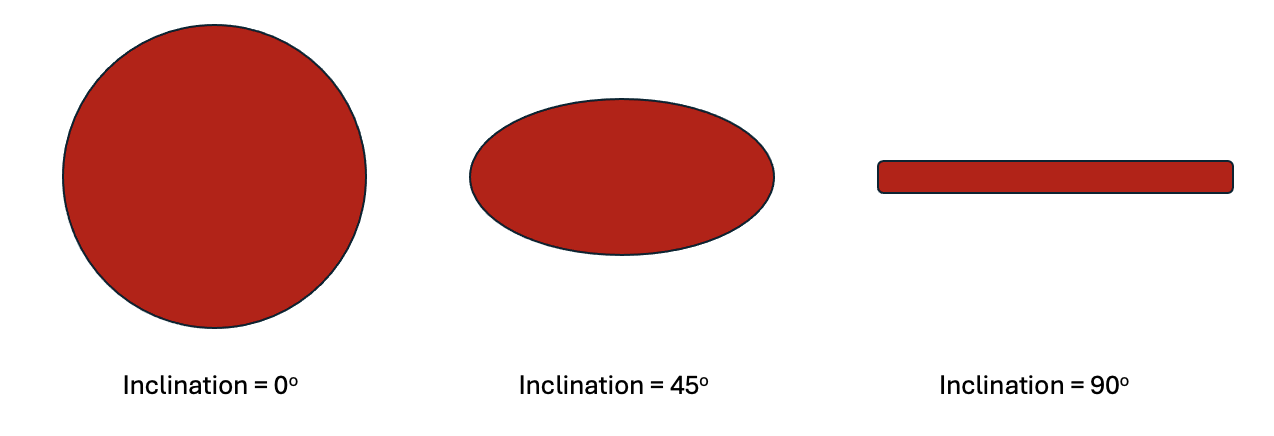

In [21]:
# For HD 163296 this is:
inc = 46.7

The second is the position angle - which measures the angle at which we view the object we see on the sky, this is traditionally measured clockwise from East, as shown below:

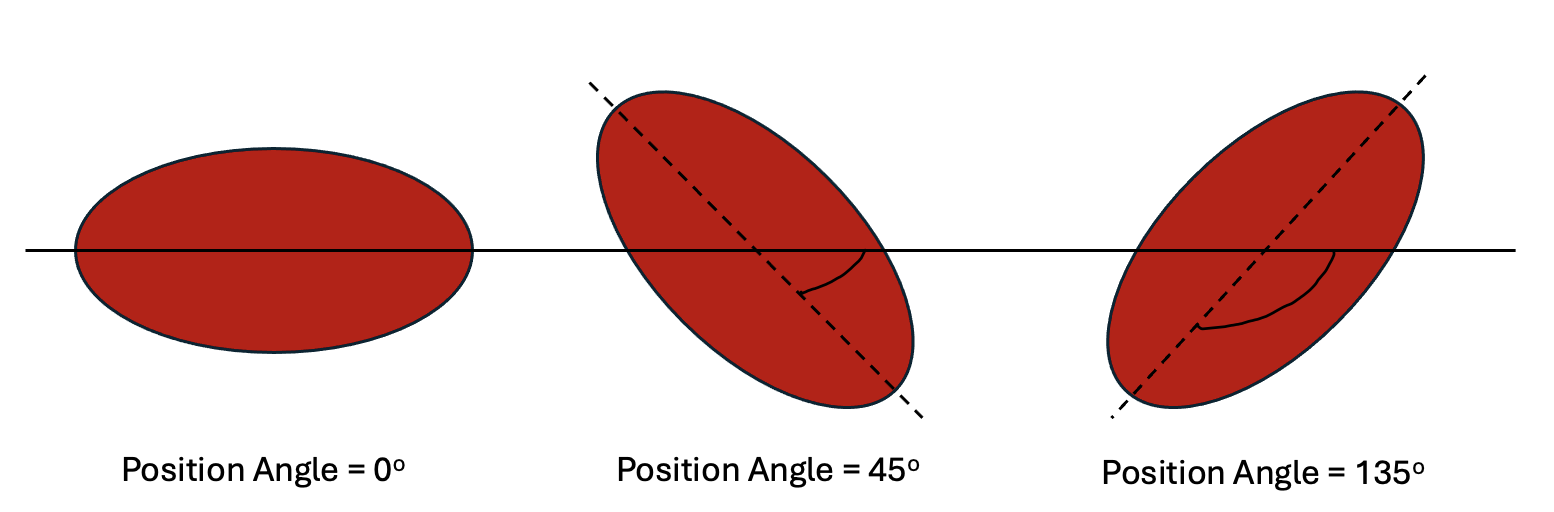

In [22]:
pa = 133.2

With these two values we are ready to proceed.

Using a useful function from the 'gofish' package, we can now azimuthally average our data. This means we will convert the brightness map into a brightness profile by averaging all emission that is found at a similar distance from the star:



In [ ]:
# The package gofish has many useful functions for analysing data:

data=imagecube(image)

# Now we extract the information we need ...
x, y, dy = data.radial_profile(inc=inc, PA=pa, unit='Jy/beam')
# Jansky/beam is a unit used by astronomers in interferometry...

# We can then take these extracted profiles and plot them
fig, ax = plt.subplots()
ax.errorbar(x, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x, y, where='mid', color='k', lw=1.0)
ax.set_xlim(x.min(), x.max())
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Intensity (Jy/beam)')


**Now we have a different view of our disc - we are just plotting intensity as a function of radius**

Intensity peaks in the y direction represent the rings we see in the image - here we see a number of peaks, each with a different radial position and amplitude.

**--- Questions ---**

How many rings can you see now? Is it more or less than before?

Are we sure there are not more hiding at low level?


One way to check for fainter rings with a smaller amplitude is to plot our profile on a log scale. We will also plot a horizontal line that shows our measured noise level to help us distinguish real rings from noisey outer regions.

In [ ]:
# Plot
x_au = x*dist
fig, ax = plt.subplots()
ax.errorbar(x_au, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.step(x_au, y, where='mid', color='k', lw=1.0)
ax.hlines(y=rms, xmin=x_au.min(), xmax=x_au.max(), colors='k', linestyles='dotted')
ax.set_xlim(x_au.min(), x_au.max())
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Intensity (Jy/beam)')
ax.set_yscale('log')

Are there any more rings?
We could do this all day... so far we have been identifying rings and gaps by eye, now it is time to do something a bit more quantitative. We can use some more python analysis tools to locate the positions of peaks within the profile:


In [26]:

sep_dist=0.048*dist
height=100
prominence = 1e-5
width=1.0

peak_locs, properties =find_peaks(y, height=rms, distance=sep_dist, prominence=prominence, width=1.0 )
# distance and prominence are key properties in the peak-finding algorithm
# you can modify these values and compare the results to get a feel for
# how they effect the result (see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html )
peak_locs_x_au=x_au[peak_locs]


Let's now visualise some of the properties we have extracted from this image

In [ ]:
fig, ax = plt.subplots()

ax.set_title(r'Radial Profile of HD163296 at $\lambda$=1.3 mm')

# First we'll plot the radial profile as before
ax.errorbar(x_au, y, dy, fmt=' ', capsize=1.25, capthick=1.25, color='k', lw=1.0)
ax.plot(x_au, y,  color='k', lw=2.0)

# lets show the background noise value that we measured
ax.hlines(y=rms, xmin=x_au.min(), xmax=x_au.max(), colors='red', linestyles='dotted')

# and lets also mark the locations at which we've identified rings

ax.vlines(x=peak_locs_x_au, ymin=0, ymax=2*np.max(y), colors='blue', linestyle='dotted')

# we can also zoom in to the part of the plot we are most interested in
ax.set_xlim(x_au.min(), 250)
ax.set_ylim(1e-5, 5e-3)

ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Intensity (Jy/beam)')
ax.set_yscale('log')

figure_text='Rings identified at:'
for i in peak_locs_x_au:
  figure_text+='\nR = {:.0f} au'.format(i)
plt.annotate(figure_text, xy=(160, 5e-4))


# Gap Analysis

**Whilst the rings look spectacular in the image, what we are really interesed in is the gaps. This is because we are expecting the planets that carve these features to reside within the middle of the gaps, rather than within the rings where dust is accumulating.**

If we can measure some properties of the gaps that exist within this disc, we can use an equation from published work (Lodato et al., 2019, MNRAS, 486, 453), that estimates the minimum mass of a planet that would be required to carve such a gap in the disc. The equation itself draws from the results of extensive modelling of situations like this.

$ M_{\rm planet} = (\frac{\Delta}{k r})^3 \times 3M_*$ ,

where $ M_{\rm planet} $ is the planet's mass, $\Delta$ is the width of the gap, $r$ is the radial position of the gap, and $k$ is a constant which contains a lot of the underlying physics in the protoplanetary disc.

In [28]:
def planet_mass_from_ring(delta, k , r, mstar):
  Mpl= 3* mstar *(delta/(k*r))**3
  return Mpl

**Now lets do similar to before, but as we are searching for gaps (i.e. minimum points) instead of peaks, we will invert the profile:**

In [ ]:

fig, ax = plt.subplots()

new_y=-y + np.abs(np.min(-y))

ax.plot(x_au, new_y , color='k', lw=1.0)
ax.set_xlim(x_au.min(), x_au.max())
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Intensity (Jy/beam)')
ax.set_yscale('log')

**Then we can use the same function as before to locate the gaps.**

In [ ]:

gap_locs, properties =find_peaks(new_y, height=rms, distance=sep_dist, prominence=prominence, width=1.0 )
# distance and prominence are key properties in the peak-finding algorithm
# you can modify these values and compare the results to get a feel for
# how they effect the result

gap_locs_x_au=x_au[gap_locs]

print('Gap locations: {}'.format(gap_locs_x_au))

**Now lets calculate our width values and plug them into the equation**

In [32]:
au=const.au.value
r=peak_locs_x_au*au
# We need to convert out radial distances into units of au, or astronomical units
# 1 au is the distance from the Earth to the Sun

delta=(peak_locs_x_au-gap_locs_x_au)*au
# Next we measure the width of the gaps from the peak of the ring to the minimum
# in the gap. We have measured all the neccesary information to calculate this

k=5.0 #This factor is debated in the literature, values between 4.5-8 seem sensible




**and finally, we need the mass of the star that hosts our disc. We can find this from published works on the object, for HD 163296 this is 2x the mass of the Sun:**

In [33]:
mstar=2.0*const.M_sun.value

**Now we are ready to estimate our planet masses!**

In [ ]:
planet_masses=planet_mass_from_ring(delta, k , r, mstar)
pl_mass=planet_masses/const.M_jup.value

print('Potential planet masses based on observed rings and gaps: {} Jupiter Masses'.format(pl_mass))

**---Questions---**

How does this compare to the disc mass in solid we calculate earlier?

What might this say about the evolutionary state of our protoplanetary disc? Is it nearly done with planet formation? Or just starting?



---



# Where do our new worlds fit in the big picture?

Methods for investigating planets such as the one we have used today are known as 'indirect', because they infer information about exoplanets based on the influence that they have on their surroundings.

Other methods of direct exoplanet detection exist, each of which are most sensitive to different types of planets due to the method by which they use to detect them (e.g. see https://exoplanets.nasa.gov/alien-worlds/ways-to-find-a-planet/?intent=021 )

Let's compare our potential planets with those that have previously been detected through these alternative methods...

**NASA maintains an archive of all confirmed exoplanets, and the data is freely available. This means we can compare the mass of these planets and the size of their orbits:**

In [ ]:
file_id='1dDoHNkmX8NBMUiHFQDHpHBnNfEv4kji_'

outputfile='exoplanets_archive.csv'
gdown.download(f"https://drive.google.com/uc?id={file_id}",outputfile, quiet=False)

**First we can read in and prepare the detection data for plotting**

In [36]:
# read in confirmed exoplanet data
detected=np.genfromtxt('exoplanets_archive.csv', delimiter=',', skip_header=3, dtype=str)

det_r_au=np.asarray(detected[:,2], dtype=float)
det_pl_jup= np.asarray(detected[:,3], dtype=float)
det_method= detected[:,1]

# construct a dataframe and assign colours for different detection methods
import matplotlib.cm as cm
df = pd.DataFrame({'R': det_r_au, 'M': det_pl_jup, 'method': det_method})
unique_methods = df['method'].unique()
colors = cm.get_cmap('tab10', len(unique_methods))
method_to_color = {method: colors(i) for i, method in enumerate(unique_methods)}


**Now lets plot our planets alongside all the confirmed exoplanets**

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot confirmed detections
for method in unique_methods:
    subset = df[df['method'] == method]
    plt.scatter(subset['R'], subset['M'], color=method_to_color[method], label=method)
# Now plot our potential planets
plt.plot(gap_locs_x_au, pl_mass, marker='o', markersize=7, mew=3,linestyle='None', mec='k', c='None', label='Our inferred planets')

plt.xlabel('Orbit semi-major axis (au)')
plt.ylabel('Planet Mass (Jupiter Masses)')
plt.legend(title='Detection Method', )
plt.xscale('log')
plt.yscale('log')
plt.xlim(3e-3,5e4)
plt.title('Inferred gap planets vs. Confirmed detected exoplanets')
plt.show()

**---Questions---**

Where have our inferred planets landed on the Mass x semi-major axis plot? What does this tell us about using dust substructures as an (indirect) method of searching for planets?

What other planet detection method(s) would be the best to choose for a successful follow up?

How do our planets compare to planets within our own Solar System? Can you find the mass and orbital radius of the Solar System planets and add them to this plot? Remember to convert to the correct units!

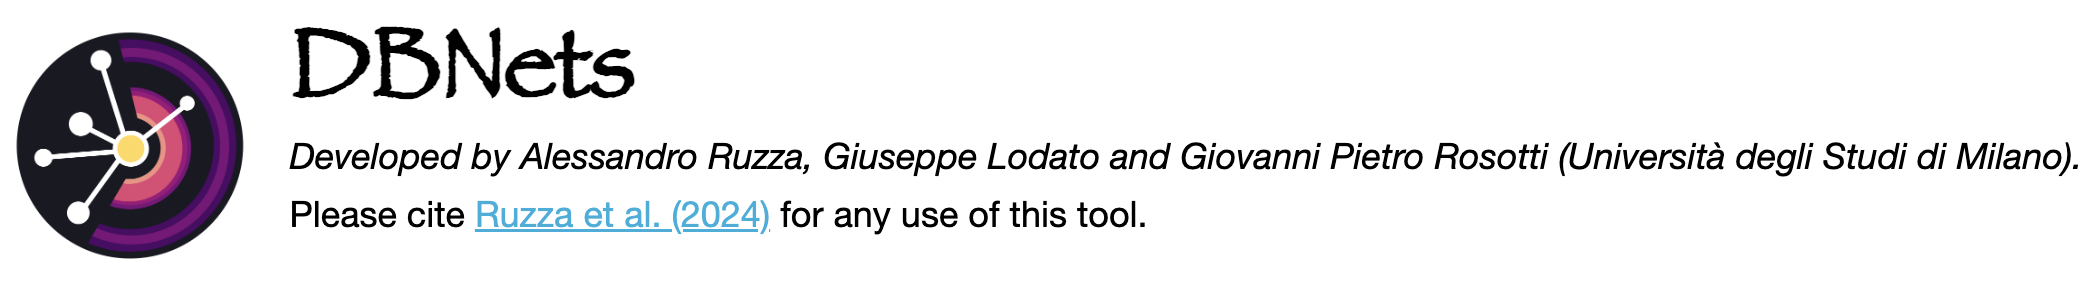

# Comparison with a Deep Learning approach

Earlier this year a paper ([Ruzza et al., 2024, A&A 685, A65](https://https://arxiv.org/pdf/2402.12448)) was published advertising a new tool, 'DBNets', which aims to do exactly as we have done above but using convolutional neural networks. The network was trained on synthetic images made from simulations of planets forming within protoplanetary discs.

**Let's compare our results to those achieved using DBNets:**


 Use the online interface to DBNets to make quick calcualtions at https://dbnets.fisica.unimi.it/


It is also possible to download a python library for local use at the following link https://github.com/dust-busters/DBNets/tree/main , for more extensive inivestigations. Installing this correctly can take some time, for the purposes of this workshop use the link above

DBNets will need some inputs, all of which you have in hand.

You can download the fits file from the 'Files' tab on the left of this notebook. You will also need to input the following information. Then you can enter each planetary radius (i.e. gap location) that we have found, and compare the calculated mass to that which we achieved with the analytic equation above.




In [ ]:
print('Inclination = {} \n Position Angle = {} \n Distance = {} \n Centre = {},{} \n Pixel Scale = {} \n'.format(inc, pa, dist, header['CRPIX1'], header['CRPIX2'], np.abs(header['CDELT1']) ))

**---Questions---**

What was the difference between the mass you calculated and the mass achieved by DBNets?

A benefit of DBNets is the calculation of uncertainties on the mass, is your calculated value consistent with the DBNets results to within the uncertainties?

Are the DBNets masses typically larger or smaller than the results we calculated above?

# Extension task: Investigate another system


The exercise above gives an example of steps to run a basic analysis of a high resolution observation of a protoplanetary disc.

You can now use this framework to explore other systems by adjusting the key system-specific parameters that we have entered above.


**This time we will inspect you to do some investigation of your own**

You will need to download the data, and find some properties of the discs.


You can download two further continuum images of the discs AS209 and Elias24 by editing the gdown download steps above to either of the following:

AS 209:

```
file_id='1hfDnoUmQtwNyHrruL_Uw6WZyCEuYbgAs'
outputfile='AS209_continuum.fits'
```

Elias 24:



```
file_id='1cAhZs8rBbWN1lwX5pENrPzXv8Gzwqf27'
outputfile='Elias24_continuum.fits'
```


You can find all the source-specific information such as inclination, position angle, distance and more, from the paper Andrews et al. 2018 at this link https://arxiv.org/pdf/1812.04040

You can also check your results against a published paper which carries out a very similar analysis at a professional level: Huang et al. 2018, https://arxiv.org/pdf/1812.04041


**---Questions---**

How do the new planets you find in these two other object compared to those of HD163296? Are they in the same region of the mass x semi major axis plot?

Can you see a link between the types of substructure in each of the discs and the masses of planets that you calculate for them?

Does DBNets find similar results to yours for these two new cases?
